# Chapter 14

In [1]:
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

1. A CNN uses far fewer parameters than a fully connected network which means they are more computationally efficient for training & inference. For example, for a typical iphone picture of shape (4032, 3024, 3), a single fully connected layer of 100 neurons (probably not enough) would have $$(4032 \times 3024 \times 3\ + 1)\times 100 = 3,657,830,500$$ trainable parameters. Because a single filter uses the same weights over an entire image, it can learn patterns that are invariant to translations.

2.  Consider a CNN composed of three convolutional layers, each with 3 × 3 kernels, a stride of 2, and "same" padding. The lowest layer outputs 100 feature maps, the middle one outputs 200, and the top one outputs 400. The input images are RGB images of 200 × 300 pixels: 

    a. What is the total number of parameters in the CNN?

    - Each filter is going to have $3 \times 3 \times \#channels + 1$. 
    
    - This is 28 for the first layer, 901 for the second, and 1,801 for the third.

    - Since there are 100 filters in the first layer, 200 in the next, and 400 in the third layer, we have a total of:$$28 \times 100 + 901 \times 200 + 1,801 \times 400 = 903,400 \ \text{parameters.}$$

    b. If we are using 32-bit floats, at least how much RAM will this network require when making a prediction for a single instance?

    - During inference the RAM occupied by one layer can be released as soon as the next layer has been computed.
    
    - Therefore, the total RAM needed to make predictions is as much RAM as required by two consecutive layers.

    - Because padding is set to "same" and stride is 2, the output of each layer will be half the size of its input (rounding up), $$(200, \ 300, \ 3) \rightarrow (100, \ 150, \ 100) \rightarrow (50, \ 75, \ 200) \rightarrow (25, \ 38, \ 400)$$

    - The first two layers have the largest outputs so the network will need at least enough RAM to hold the outputs of these layers, i.e. $$(100 \times 150 \times 100 + 50 \times 75 \times 200) \times 32 = 72,000,000 \ \text{bits},$$ or 9 MB.

    - The model itself also needs to be kept in RAM, so that's another $903,400 \times 32 = 28,908,800 \ \text{bits},$ or 3.61 MB.

    - This gives a total of 12.61 MB.

    c. What about when training on a mini-batch of 50 images?

    - The reverse pass of backpropagation requires all the intermediative values computed during the forward pass. so 
    
    - So the total RAM needed is at least the total amount of RAM required by all layers: $$50 \times 32 \times (100 \times 150 \times 100 + 50 \times 75 \times 200 + 25 \times 38 \times 400) = 4,208,000,000 \ \text{bits},$$ or 526 MB.

    - Plus the RAM needed for the model: 3.61 MB.

    - Plus the RAM needed for the input images: $50 \times 32 \times 200 \times 300 \times 3 = 288,000,000 \ \text{bits}$, or 36 MB.

    - This totals 565.61 MB (not including memory required to store the gradients).

In [2]:
Conv = partial(keras.layers.Conv2D, kernel_size=(3, 3), padding="same", strides=2)

model = keras.Sequential(
    [
        keras.layers.Input(shape=(200, 300, 3)),
        Conv(filters=100),
        Conv(filters=200),
        Conv(filters=400),
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 150, 100)  │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 75, 200)    │       180,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 38, 400)    │       720,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 903,400 (3.45 MB)

 Trainable params: 903,400 (3.45 MB)

 Non-trainable params: 0 (0.00 B)

3. If your GPU runs out of memory during training you can try:

    - reduce the mini-batch size,

    - use 16-bit floats instead of 32-bit,

    - reduce the dimensionality by increasing the stride,

    - reduce the number of layers, or

    - distribute the CNN across multiple devices.
 
4. **Max pooling layer vs. convolutional layer with stride:** both methods shrink the image, reducing computational & memory load (and also reduce number of parameters in subsequent layers, reducing overfitting). A max pooling layer however introduces translation, scale, and rotational invariance to the model, which is ideal for tasks like classification
 
5. **Local response normalization:** a competitive normalization layer that should be added after convolutional layers to improve generalization. The most strongly activated neurons inhibit other neurons located at the same position in neighboring feature maps. This encourages different feature maps to specialize, pushing them apart and forcing them to explore a wider range of features.
 
6. Main innovations of CNN architectures compared to LeNet-5:

    - **AlexNet:**

    - **GoogleLeNet:**

    - **ResNet:**

    - **SENet:**

    - **Xception:**

    - **EfficientNet:**

7. A fully convolutional network can be created by replacing the dense layers at the top of a CNN with convolutional layers. The new convolutional layers should have as many features as neurons in the old dense layers and a kernel size that matches the image size of the previous convolutional layer with padding set to valid. The FCN is equivalent to the CNN except it can now process larger images and will output a result as if the old CNN swept across the larger image, but much more efficiently as it only needs to see the input once!

8. Semantic segmentation is difficult because images lose their spatial resolution as they pass through a regular CNN (due to pooling layers & convolutional layers with stride). One solution is to use transposed convolutional layers (like a regular convolutional layer with a fractional stride) to upsample the image.

9. Build a CNN to get the highest possible accuracy on MNIST hand written digits dataset: [Kaggle competition](https://www.kaggle.com/competitions/digit-recognizer/leaderboard) & [my code](https://github.com/edwardbickerton/Kaggle-competitions/blob/main/digit-recognizer.ipynb).

## 10. Use transfer learning for large image classification

a. Create a training set containing at least 100 images per class. For example, you could classify your own pictures based on the location (beach, mountain, city, etc.), or alternatively you can use an existing dataset (e.g., from TensorFlow Datasets).

In [3]:
DATA_DIR = Path("datasets/14/my_image_data")
class_labels = ("dog", "hiking", "sea", "skiing")


def parse_image(image_path):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)

    label = tf.strings.split(image_path, "/")[-1]
    label = tf.strings.split(label)[0]
    label = tf.where(tf.equal(class_labels, label))[0, 0]

    return image, label


dataset = (
    tf.data.Dataset.list_files(
        [str(file_path) for file_path in DATA_DIR.rglob("*.jpeg")],
        shuffle=True,
    )
    .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(100)
)

b. Split it into a training set, a validation set, and a test set.

In [4]:
test_set = dataset.take(112)
val_set = dataset.skip(112).take(112)
train_set = dataset.skip(224)

c. Build the input pipeline, apply the appropriate preprocessing operations, and optionally add data augmentation.

In [5]:
class DataAugmentationLayer(keras.Layer):
    def __init__(
        self,
        fill_value=-1.0,
        value_range=(-1.0, 1.0),
        zoom_factor=0.1,
        translation_factor=0.1,
        rotation_factor=0.05,
        brightness_factor=0.25,
        flip_mode="horizontal",
    ):
        super().__init__()
        self.layers = [
            keras.layers.RandomBrightness(brightness_factor, value_range=value_range),
            keras.layers.RandomFlip(mode=flip_mode),
            keras.layers.RandomZoom(
                height_factor=zoom_factor,
                width_factor=zoom_factor,
                fill_mode="constant",
                fill_value=fill_value,
            ),
            keras.layers.RandomTranslation(
                height_factor=translation_factor,
                width_factor=translation_factor,
                fill_mode="constant",
                fill_value=fill_value,
            ),
            keras.layers.RandomRotation(
                rotation_factor,
                fill_mode="constant",
                fill_value=fill_value,
            ),
        ]

    def call(self, inputs, training=False):
        for layer in self.layers:
            inputs = layer(inputs, training=training)
        return inputs

In [6]:
class PreprocessLayer(keras.Layer):
    def __init__(self):
        super().__init__()
        self.rescaling_layer = keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)
        self.data_augmentation_layer = DataAugmentationLayer()
        self.resize_layer = keras.layers.Resizing(
            480,
            480,
            crop_to_aspect_ratio=True,
        )

    def call(self, inputs, training=False):
        inputs = self.rescaling_layer(inputs)
        inputs = self.data_augmentation_layer(inputs, training=training)
        inputs = self.resize_layer(inputs)
        return inputs

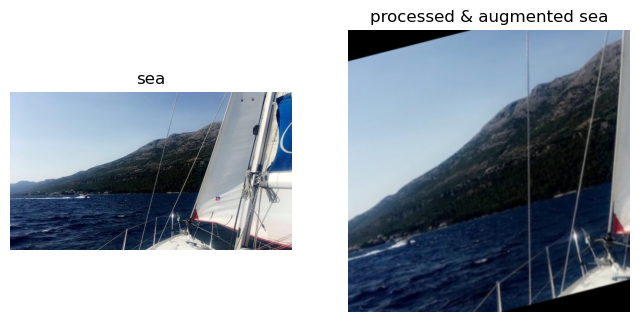

Shape: (360, 640, 3) --> (480, 480, 3)
Scale: (0, 255) --> (-1.0, 0.9723543)


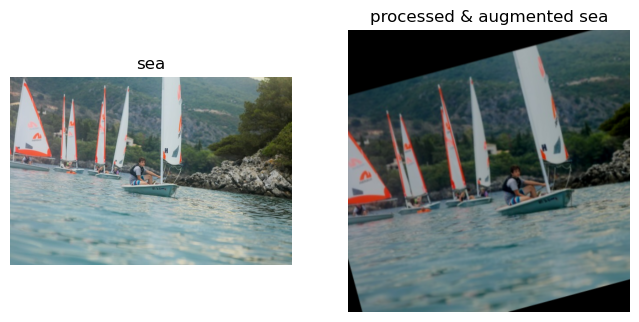

Shape: (427, 640, 3) --> (480, 480, 3)
Scale: (0, 255) --> (-1.0, 0.6094538)


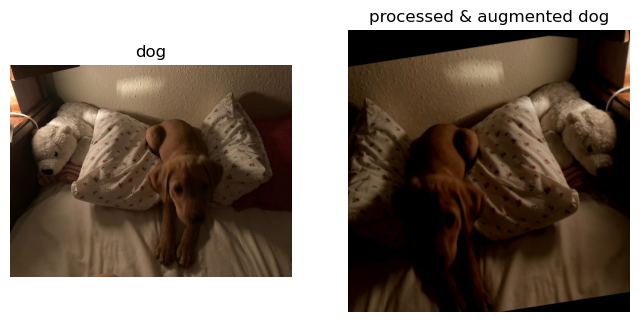

Shape: (480, 640, 3) --> (480, 480, 3)
Scale: (0, 255) --> (-1.0, 0.7250729)


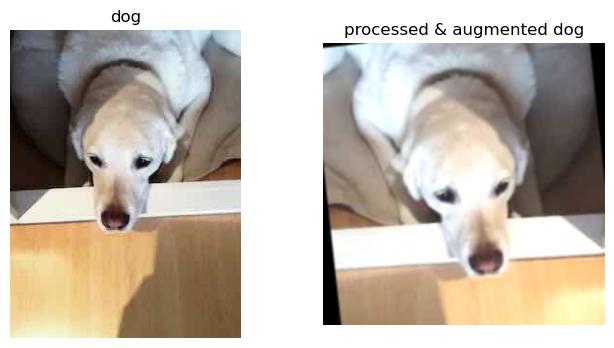

Shape: (320, 240, 3) --> (480, 480, 3)
Scale: (0, 255) --> (-1.0, 1.0)


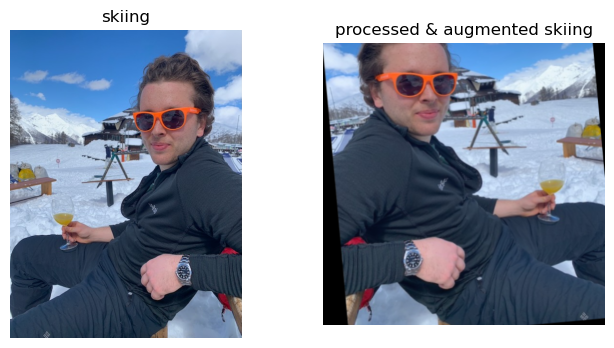

Shape: (640, 481, 3) --> (480, 480, 3)
Scale: (0, 255) --> (-1.0, 0.999646)


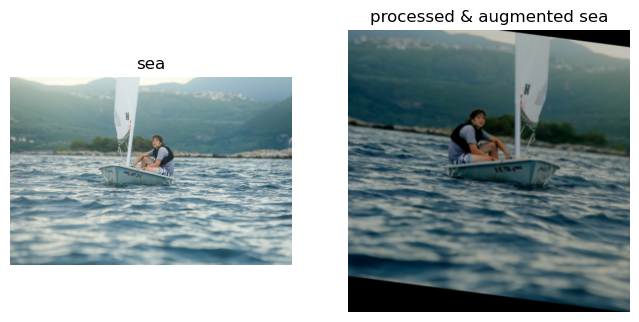

Shape: (427, 640, 3) --> (480, 480, 3)
Scale: (0, 255) --> (-1.0, 0.52277374)


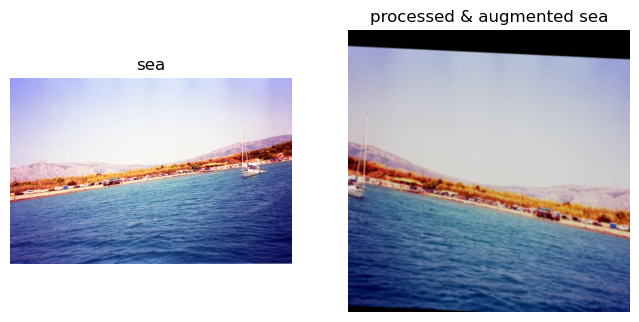

Shape: (423, 640, 3) --> (480, 480, 3)
Scale: (0, 255) --> (-1.0, 0.72933084)


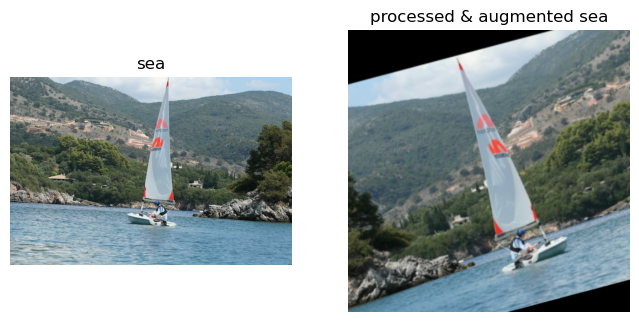

Shape: (427, 640, 3) --> (480, 480, 3)
Scale: (0, 255) --> (-1.0, 0.9811856)


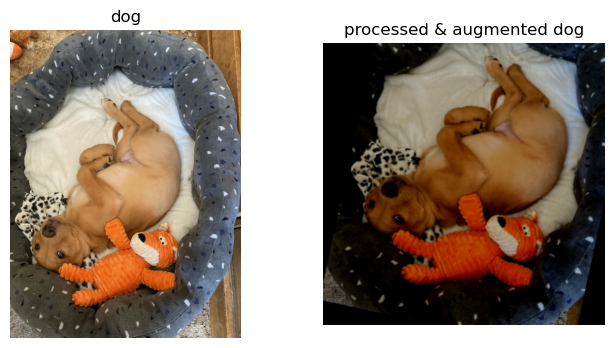

Shape: (640, 480, 3) --> (480, 480, 3)
Scale: (0, 255) --> (-1.0, 0.48327875)


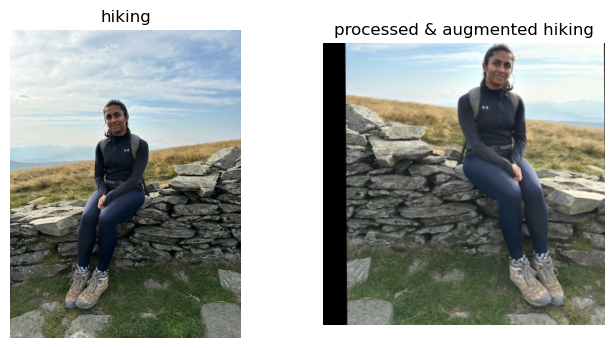

Shape: (640, 480, 3) --> (480, 480, 3)
Scale: (0, 255) --> (-1.0, 1.0)


2025-02-22 16:45:20.931354: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
sample = train_set.take(10)
preprocess_layer = PreprocessLayer()


def plot(image, title, ax=None, scale=(0, 255)):
    ax = plt.gca() if ax is None else ax

    if scale == (0, 255):
        plot_rescaling_layer = keras.layers.Rescaling(scale=1.0 / 255)
    if scale == (-1, 1):
        plot_rescaling_layer = keras.layers.Rescaling(scale=0.5, offset=0.5)

    image_copy = tf.identity(image)
    scaled_image = plot_rescaling_layer(image_copy)

    ax.imshow(scaled_image, vmin=0, vmax=1)
    ax.set_title(title)
    ax.axis("off")


for image, label in sample:
    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))

    plot(image, class_labels[label], axs[0])

    original_shape = image.shape
    original_scale = (image.numpy().min(), image.numpy().max())

    image = preprocess_layer(image, training=True)

    plot(image, f"processed & augmented {class_labels[label]}", axs[1], scale=(-1, 1))
    plt.show()
    print(
        f"Shape: {original_shape} --> {image.shape}",
        f"Scale: {original_scale} --> {(image.numpy().min(), image.numpy().max())}",
        sep="\n",
    )

In [8]:
test_set = (
    test_set.map(lambda image, label: (preprocess_layer(image), label))
    .batch(32)
    .cache()
)
val_set = (
    val_set.map(lambda image, label: (preprocess_layer(image), label)).batch(32).cache()
)
train_set = (
    train_set.cache()
    .shuffle(100)
    .map(
        lambda image, label: (preprocess_layer(image, training=True), label),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

d. Fine-tune a pretrained model on this dataset.

In [ ]:
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, starting_lr, end_lr, n_iter, log_dir=None):
        self.factor = (end_lr / starting_lr) ** (1 / n_iter)
        self.starting_lr = starting_lr
        self.end_lr = end_lr
        self.learning_rates, self.losses = [], []
        self.file_writer = (
            tf.summary.create_file_writer(log_dir + "/exp_learning_rate")
            if log_dir
            else None
        )

    def on_train_begin(self, logs=None):
        self.model.optimizer.learning_rate = self.starting_lr

    def on_train_batch_end(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy()

        if logs:
            self.learning_rates.append(lr)
            self.losses.append(logs["loss"])

        if logs and self.file_writer:
            with self.file_writer.as_default():
                tf.summary.scalar(
                    "Learning Rate",
                    lr,
                    step=batch,
                )
                tf.summary.scalar(
                    "Loss",
                    logs["loss"],
                    step=batch,
                )

        new_lr = lr * self.factor
        if new_lr > self.end_lr:
            self.model.stop_training = True
            print("\nReached end learning rate, stopping training")
        else:
            self.model.optimizer.learning_rate = new_lr


def get_run_logdir(root_logdir):
    return str(Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S"))

In [ ]:
base_model = keras.applications.EfficientNetV2M(
    include_top=False, weights="imagenet", include_preprocessing=False
)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(len(class_labels), activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

In [9]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
    metrics=["accuracy"],
)

exponential_learning_rate_cb = ExponentialLearningRate(
    1e-4, 1, 30, get_run_logdir("logs/14")
)

history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=3,
    callbacks=[exponential_learning_rate_cb],
)

Epoch 1/3


I0000 00:00:1740242742.627107 1456121 service.cc:146] XLA service 0x3438cd4d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740242742.627533 1456121 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1740242742.834676 1456121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/17 ━━━━━━━━━━━━━━━━━━━━ 333s 19s/step - accuracy: 0.7643 - loss: 0.6422 - val_accuracy: 1.0000 - val_loss: 0.0170
Epoch 2/3
17/17 ━━━━━━━━━━━━━━━━━━━━ 305s 18s/step - accuracy: 0.9929 - loss: 0.0163 - val_accuracy: 1.0000 - val_loss: 0.0083
Epoch 3/3
17/17 ━━━━━━━━━━━━━━━━━━━━ 298s 18s/step - accuracy: 0.9979 - loss: 0.0059 - val_accuracy: 1.0000 - val_loss: 0.0069


## 11. TensorFlow's [Style Transfer tutorial](https://homl.info/styletuto)